# Humanoid - przesrzeń ciągła
#### Szymon Frączek, Piotr Gąsiorek
---

Środowiskiem, które testowaliśmy był Humanoid. Jest to środowisko z przestrzenią ciągłą, w którym agent steruje humanoidem, próbującym nauczyć się chodzenia. Humanoid jest bardziej złożonym środowiskiem, co sprawia, że uczenie agenta jest bardziej wymagające.

### Instalacja środowiska
Instalujemy wymagane biblioteki jak gymnasium, numpy, matplotlib, stable_baselines3.

In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import SAC, TD3, A2C
import matplotlib.pyplot as plt
import os

### Zdefiniowanie folderu do zapisywania wyników

In [ ]:
models_dir = 'models'
logs_dir = 'logs'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

### Metoda uczenia
W ramach naszego projektu przeprowadziliśmy eksperymenty mające na celu porównanie wydajności trzech różnych algorytmów uczenia ze wzmocnieniem: A2C (Advantage Actor-Critic), SAC (Soft Actor-Critic) oraz TD3 (Twin Delayed DDPG). Dla każdego z algorytmów, obserwowaliśmy dwie kluczowe metryki w czasie: średnią nagrodę na epizod (rollout/ep_rew_mean) oraz średnią długość epizodu (rollout/ep_len_mean), zgodnie z poniższymi wykresami.

In [ ]:
def train(env, sb3_algo, max_iters=20, model=None, curr_name=None):

    if model is None:
        match sb3_algo:
            case 'SAC':
                model = SAC('MlpPolicy', env, verbose=1, tensorboard_log=logs_dir)
            case 'TD3':
                model = TD3('MlpPolicy', env, verbose=1, tensorboard_log=logs_dir)
            case 'A2C':
                model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=logs_dir)
            case _:
                print('Invalid algorithm')
                return
        name = f'{models_dir}/{sb3_algo}'
    else:
        if curr_name is None:
            print('Please provide a name for the model')
            return
        name = curr_name
        model.set_env(env)

    TIMESTEPS = 25000
    iters = 0
    while True and iters < max_iters:
        iters +=1
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False)
        model.save(f'{name}_{TIMESTEPS*iters}')

### Metoda testująca agenta

In [ ]:
def test(env, sb3_algo, path_to_model):
    match sb3_algo:
        case 'SAC':
            model = SAC.load(path_to_model)
        case 'TD3':
            model = TD3.load(path_to_model)
        case 'A2C':
            model = A2C.load(path_to_model)
        case _:
            print('Invalid algorithm')
            return

    obs = env.reset()[0]
    done = False
    extra_steps = 500
    while True:
        action, _states = model.predict(obs)
        obs, _, done, _, _ = env.step(action)
        
        if done:
            extra_steps -= 1

        if extra_steps < 0:
            break

### Definicja środowiska oraz trening agenta

In [ ]:
gymenv = gym.make('Humanoid-v4', render_mode=None)
gymenv_test = gym.make('Humanoid-v4', render_mode='human')

In [ ]:
# train(gymenv, 'SAC')
# train(gymenv, 'TD3')
# train(gymenv, 'A2C')

In [ ]:
test(gymenv_test, 'SAC', 'models/SAC3_continued_400000')

In [ ]:
model = SAC.load('models/SAC2_continued_100000')
# train(gymenv, 'SAC', model=model, curr_name='models/SAC3_continued')
# test(gymenv_test, 'SAC', 'models/SAC2_continued_100000')

### Porównanie algorytmów uczenia

#### Średnia Nagroda na Epizod (rollout/ep_rew_mean):
Wykres przedstawia zbieżność algorytmów A2C, SAC i TD3 pod względem średniej nagrody otrzymywanej na epizod. Widoczny jest wyraźny podział wydajności:
- **SAC (ciemnoszary)** osiągnął wyraźnie najlepsze wyniki, z początkowym szybkim wzrostem i następnie stabilną poprawą, osiągając średnią nagrodę około 895.65. Ta wydajność pokazuje, że SAC jest najbardziej skuteczny.
- **A2C (różowy)** wykazał się znacznie niższą wydajnością z nagrodą oscylującą wokół 148.50, co może wskazywać na trudności algorytmu w eksploracji lub eksploatacji środowiska.
- **TD3 (błękitny)** uzyskał najniższą średnią nagrodę, w przybliżeniu równą 84.20, co pokazuje, że jego podejście do uczenia w tym konkretnym przypadku jest mniej skuteczne niż SAC i A2C.

#### Średnia Długość Epizodu (rollout/ep_len_mean):
Drugi wykres przedstawia średnią długość epizodu dla tych samych algorytmów.
- **SAC (ciemnoszary)** utrzymuje najwyższą średnią długość epizodu, sugerując, że agent potrafi pozostać aktywny przez dłuższe okresy, co w połączeniu z wysoką nagrodą wskazuje na ogólną efektywność tego podejścia.
- **A2C (różowy)** i **TD3 (błękitny)** mają znacznie krótsze epizody, co może oznaczać szybkie zakończenie epizodów przez brak postępów lub osiągnięcie terminalnego stanu środowiska.

#### Podsumowanie:
Eksperymenty pokazują, że w naszym środowisku testowym algorytm SAC wyraźnie przewyższa A2C i TD3 zarówno pod względem nagrody, jak i długości epizodu. Wysoka wartość nagrody oraz długości epizodu związane z SAC sugerują, że jest on zdolny do skutecznej nauki i interakcji ze środowiskiem. W przeciwieństwie do tego, A2C i TD3 nie osiągają podobnych wyników. Algorytmy A2C i TD3 potrzebują modyfikacji lub innych parametrów w celu poprawy wydajności w badanym scenariuszu.

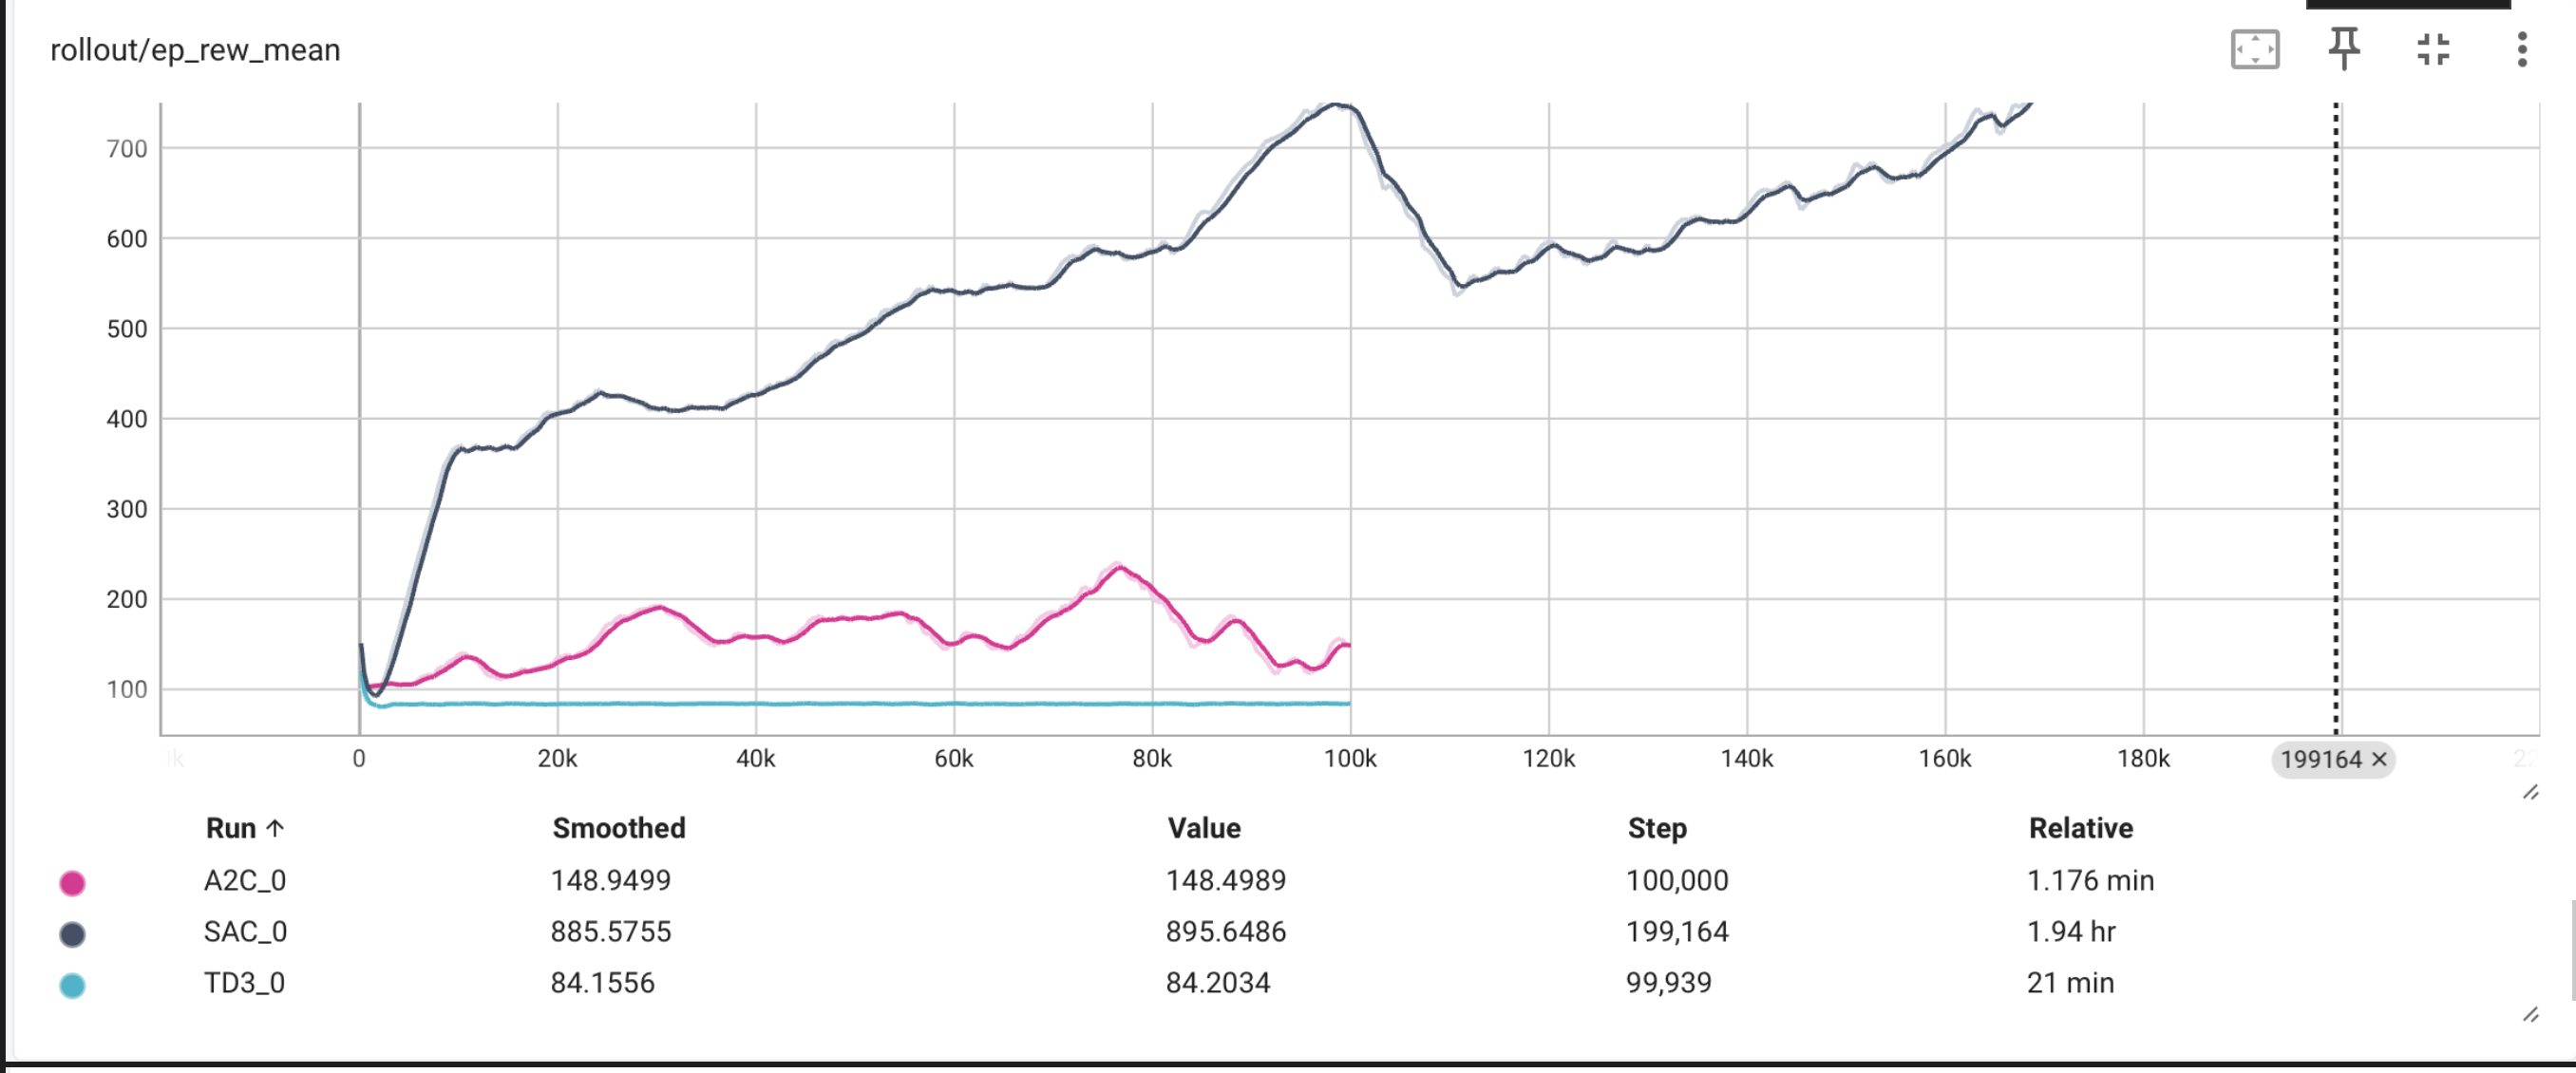
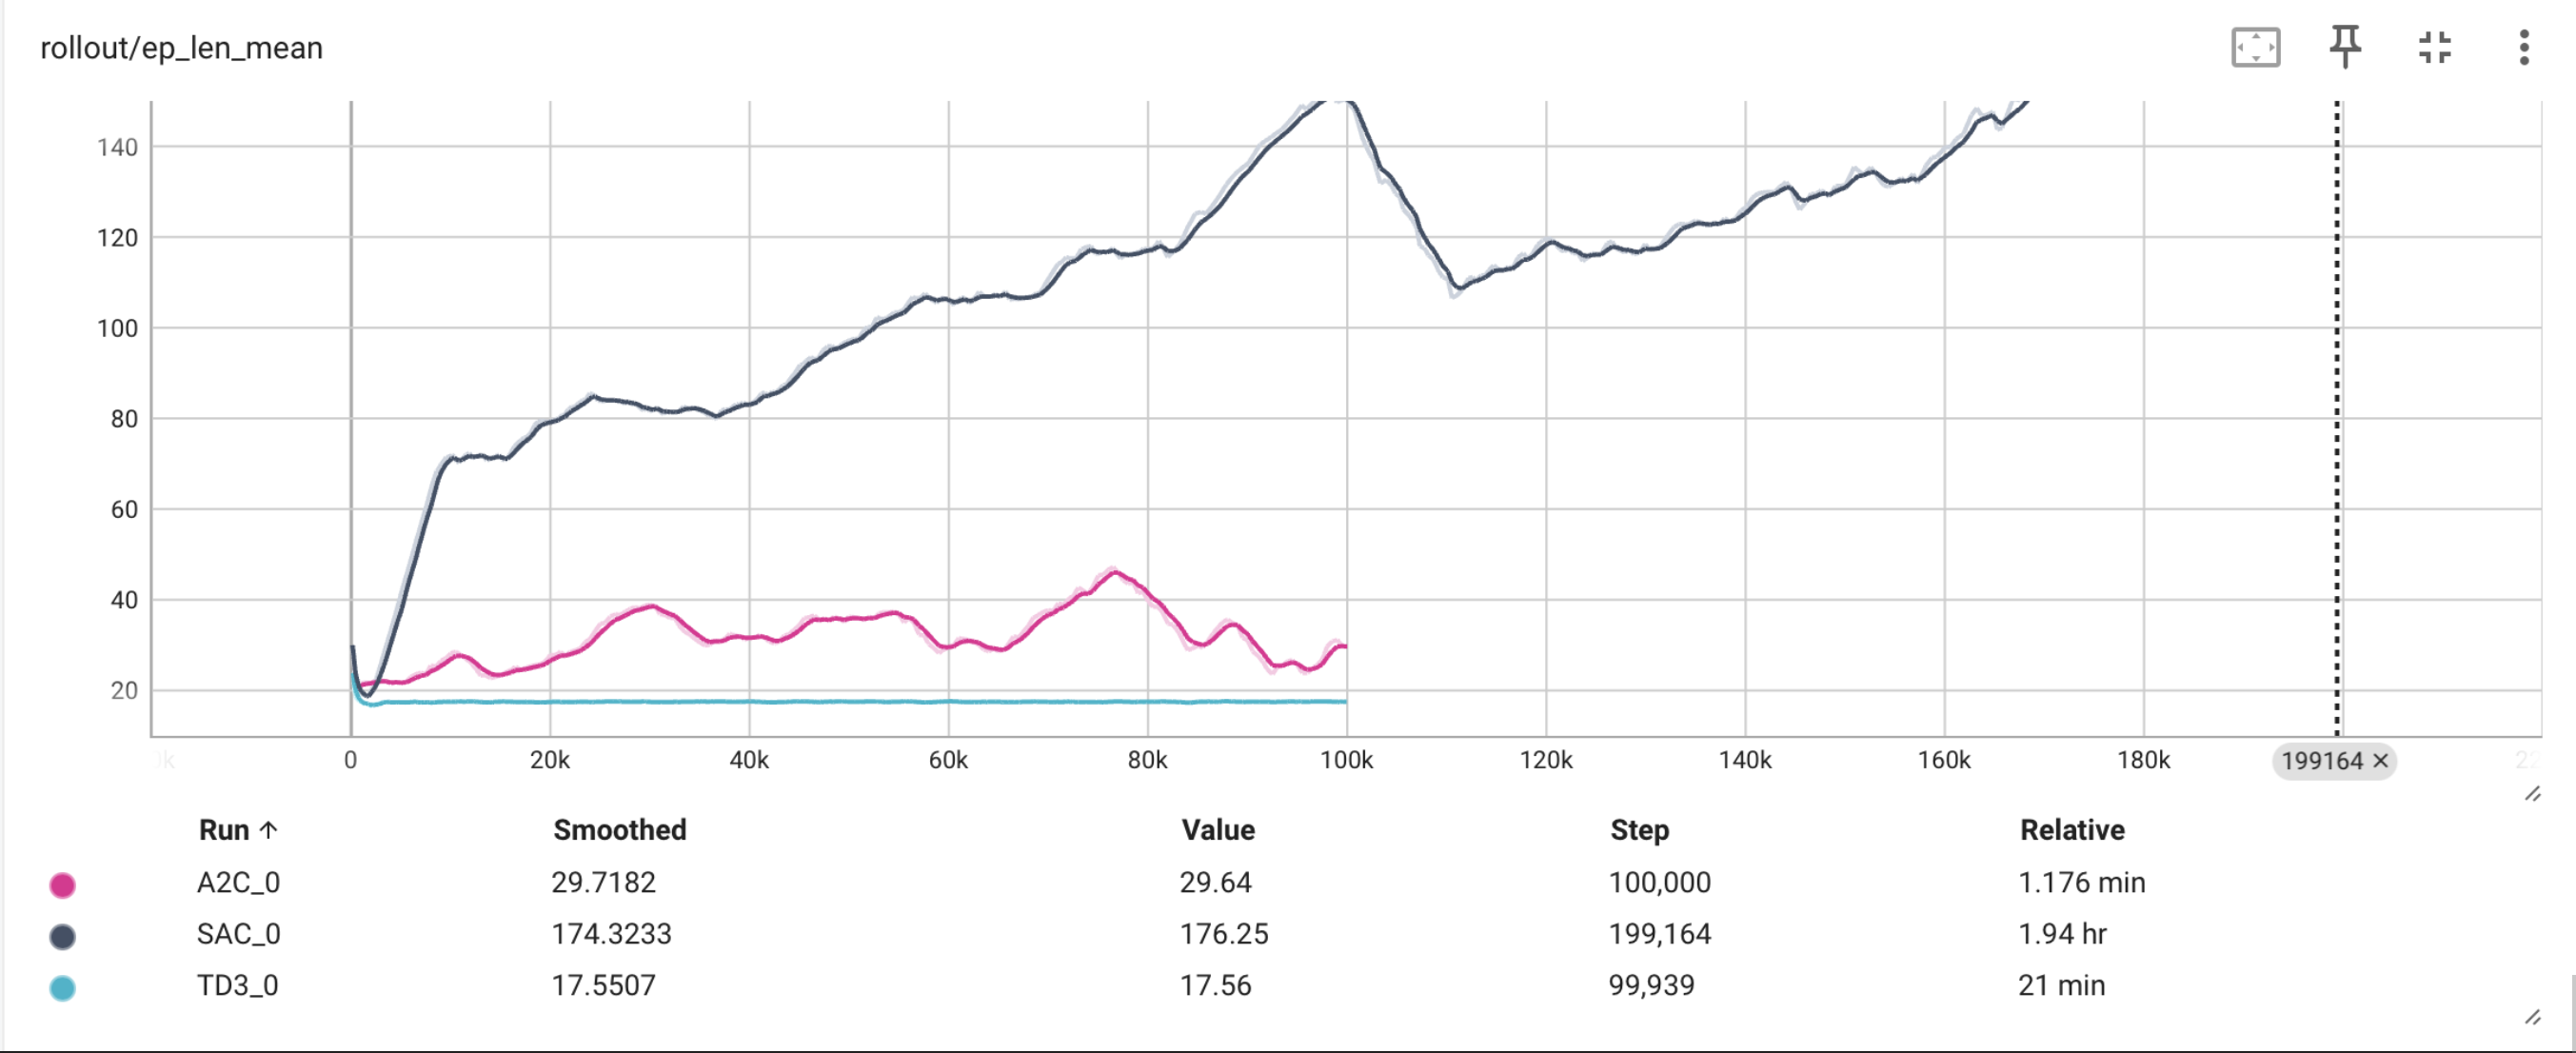
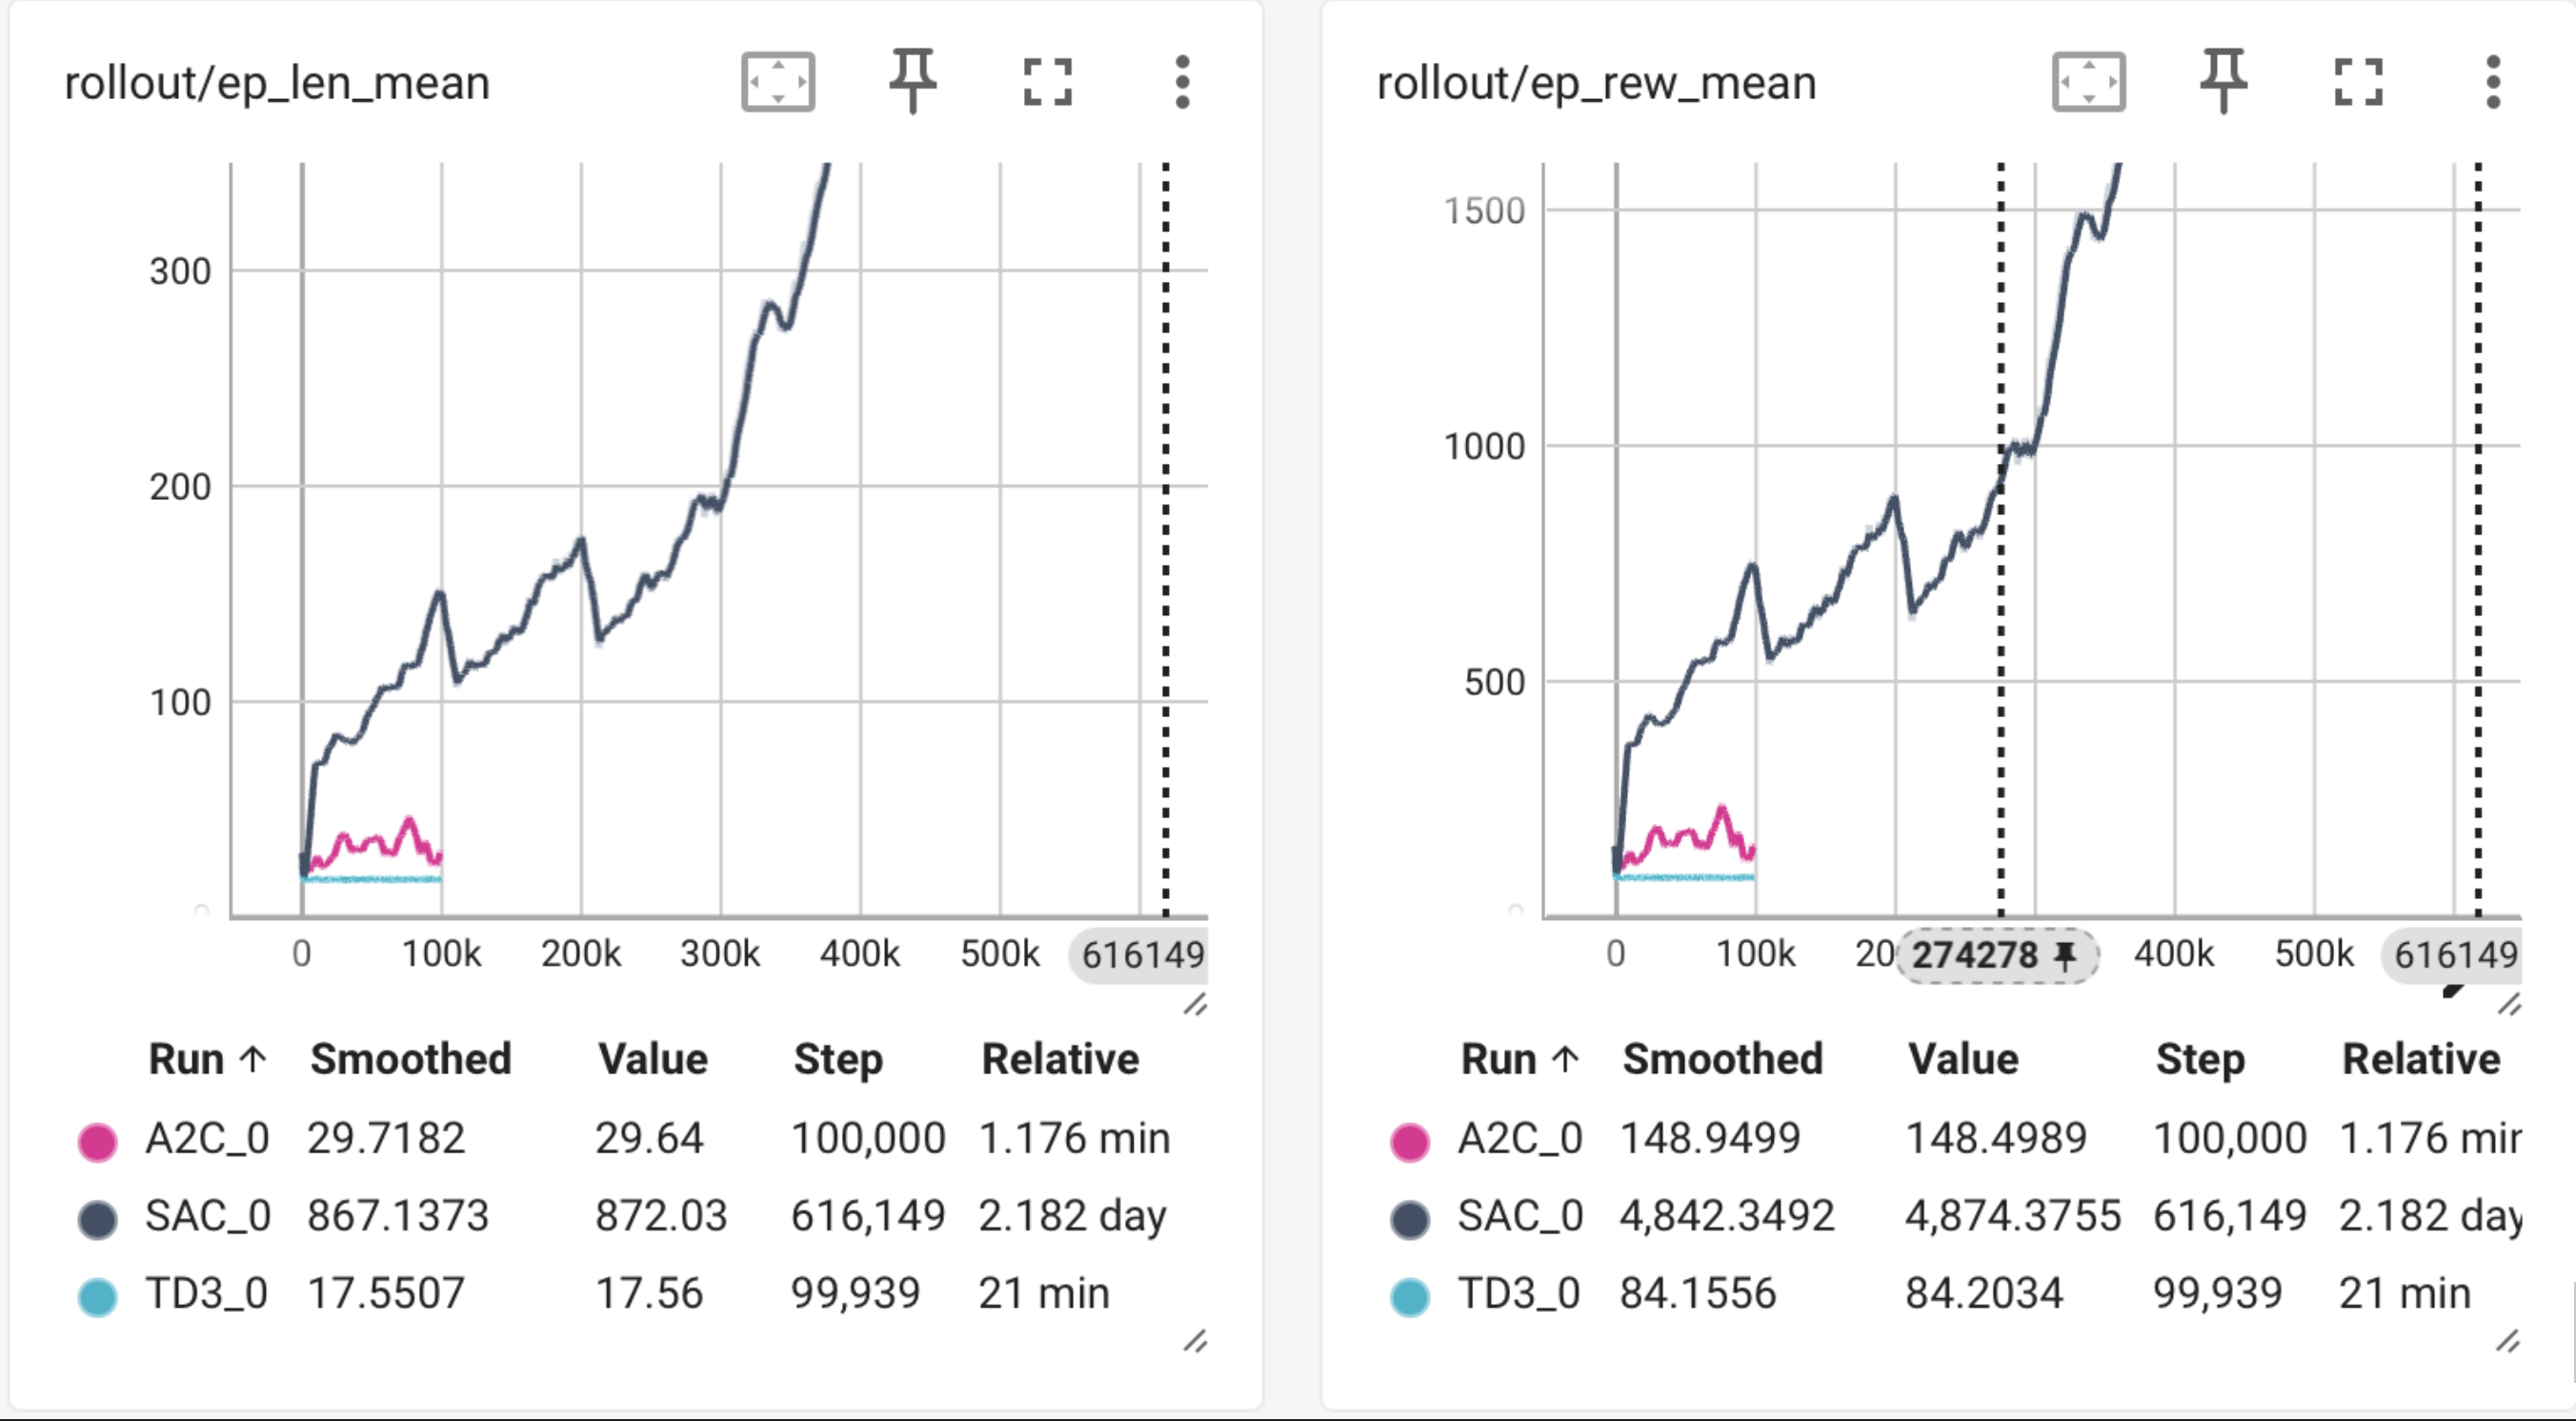

Przeprowadziliśmy równie eksperymenty na róznych wartościach gamma. Jest to liczba z zakresu od 0 do 1, która  pomaga określić, jak silnie przyszłe nagrody wpływają na obecną decyzję agenta. Wartość gamma bliska 0 oznacza, że agent skupia się głównie na natychmiastowych nagrodach, podczas gdy wartość bliska 1 sugeruje, że przyszłe nagrody są niemal równie ważne jak te bieżące.

In [ ]:
def train(env, sb3_algo, max_iters=4, model=None, curr_name=None, gamma=0.99):
    gamma_str = str(gamma).replace('.', '_')
    if model is None:
        match sb3_algo:
            case 'SAC':
                model = SAC('MlpPolicy', env, verbose=1, tensorboard_log=f'{logs_dir}/SAC_gamma{gamma_str}')
            case 'TD3':
                model = TD3('MlpPolicy', env, verbose=1, tensorboard_log=f'{logs_dir}/TD3_gamma{gamma_str}')
            case 'A2C':
                model = A2C('MlpPolicy', env, verbose=1, tensorboard_log=f'{logs_dir}/A2C_gamma{gamma_str}')
            case _:
                print('Invalid algorithm')
                return
        name = f'{models_dir}/{sb3_algo}_gamma{gamma_str}'
    else:
        if curr_name is None:
            print('Please provide a name for the model')
            return
        name = curr_name
        model.set_env(env)

    os.makedirs(name, exist_ok=True)
    TIMESTEPS = 25000
    iters = 0
    while iters < max_iters:
        iters += 1
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False)
        model.save(f'{name}/{TIMESTEPS*iters}')

def test(env, sb3_algo, path_to_model):
    match sb3_algo:
        case 'SAC':
            model = SAC.load(path_to_model)
        case 'TD3':
            model = TD3.load(path_to_model)
        case 'A2C':
            model = A2C.load(path_to_model)
        case _:
            print('Invalid algorithm')
            return

    obs = env.reset()[0]
    done = False
    extra_steps = 500
    while True:
        action, _states = model.predict(obs)
        obs, _, done, _, _ = env.step(action)
        
        if done:
            extra_steps -= 1

        if extra_steps < 0:
            break

In [ ]:
gymenv = gym.make('Humanoid-v4', render_mode=None)
train(gymenv, 'SAC', gamma=0.99)
train(gymenv, 'SAC', gamma=0.9)
train(gymenv, 'SAC', gamma=0.8)
train(gymenv, 'SAC', gamma=0.5)
train(gymenv, 'SAC', gamma=0.1)

Wykresy z przebiegu doświadczenia na przestrzeni 100000 epizodów.

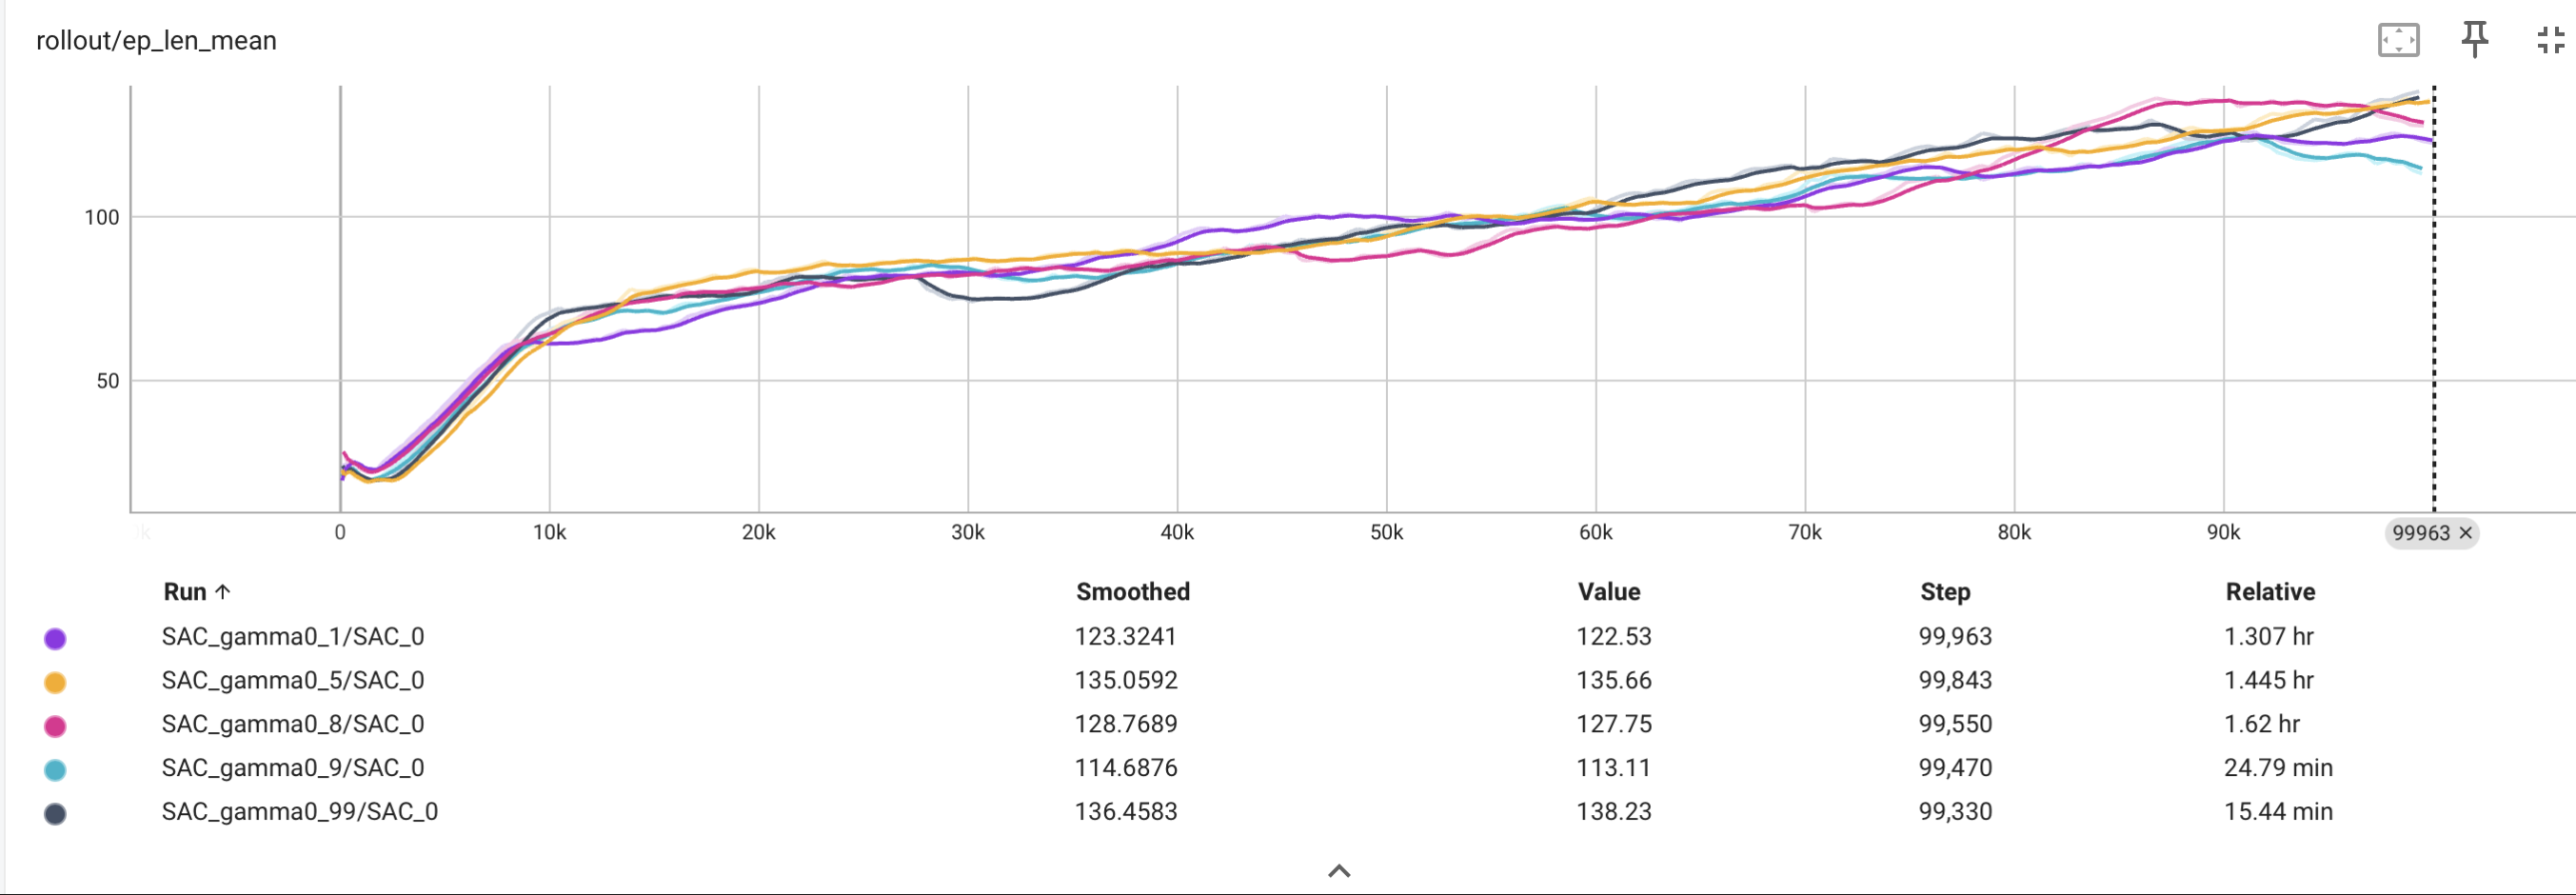
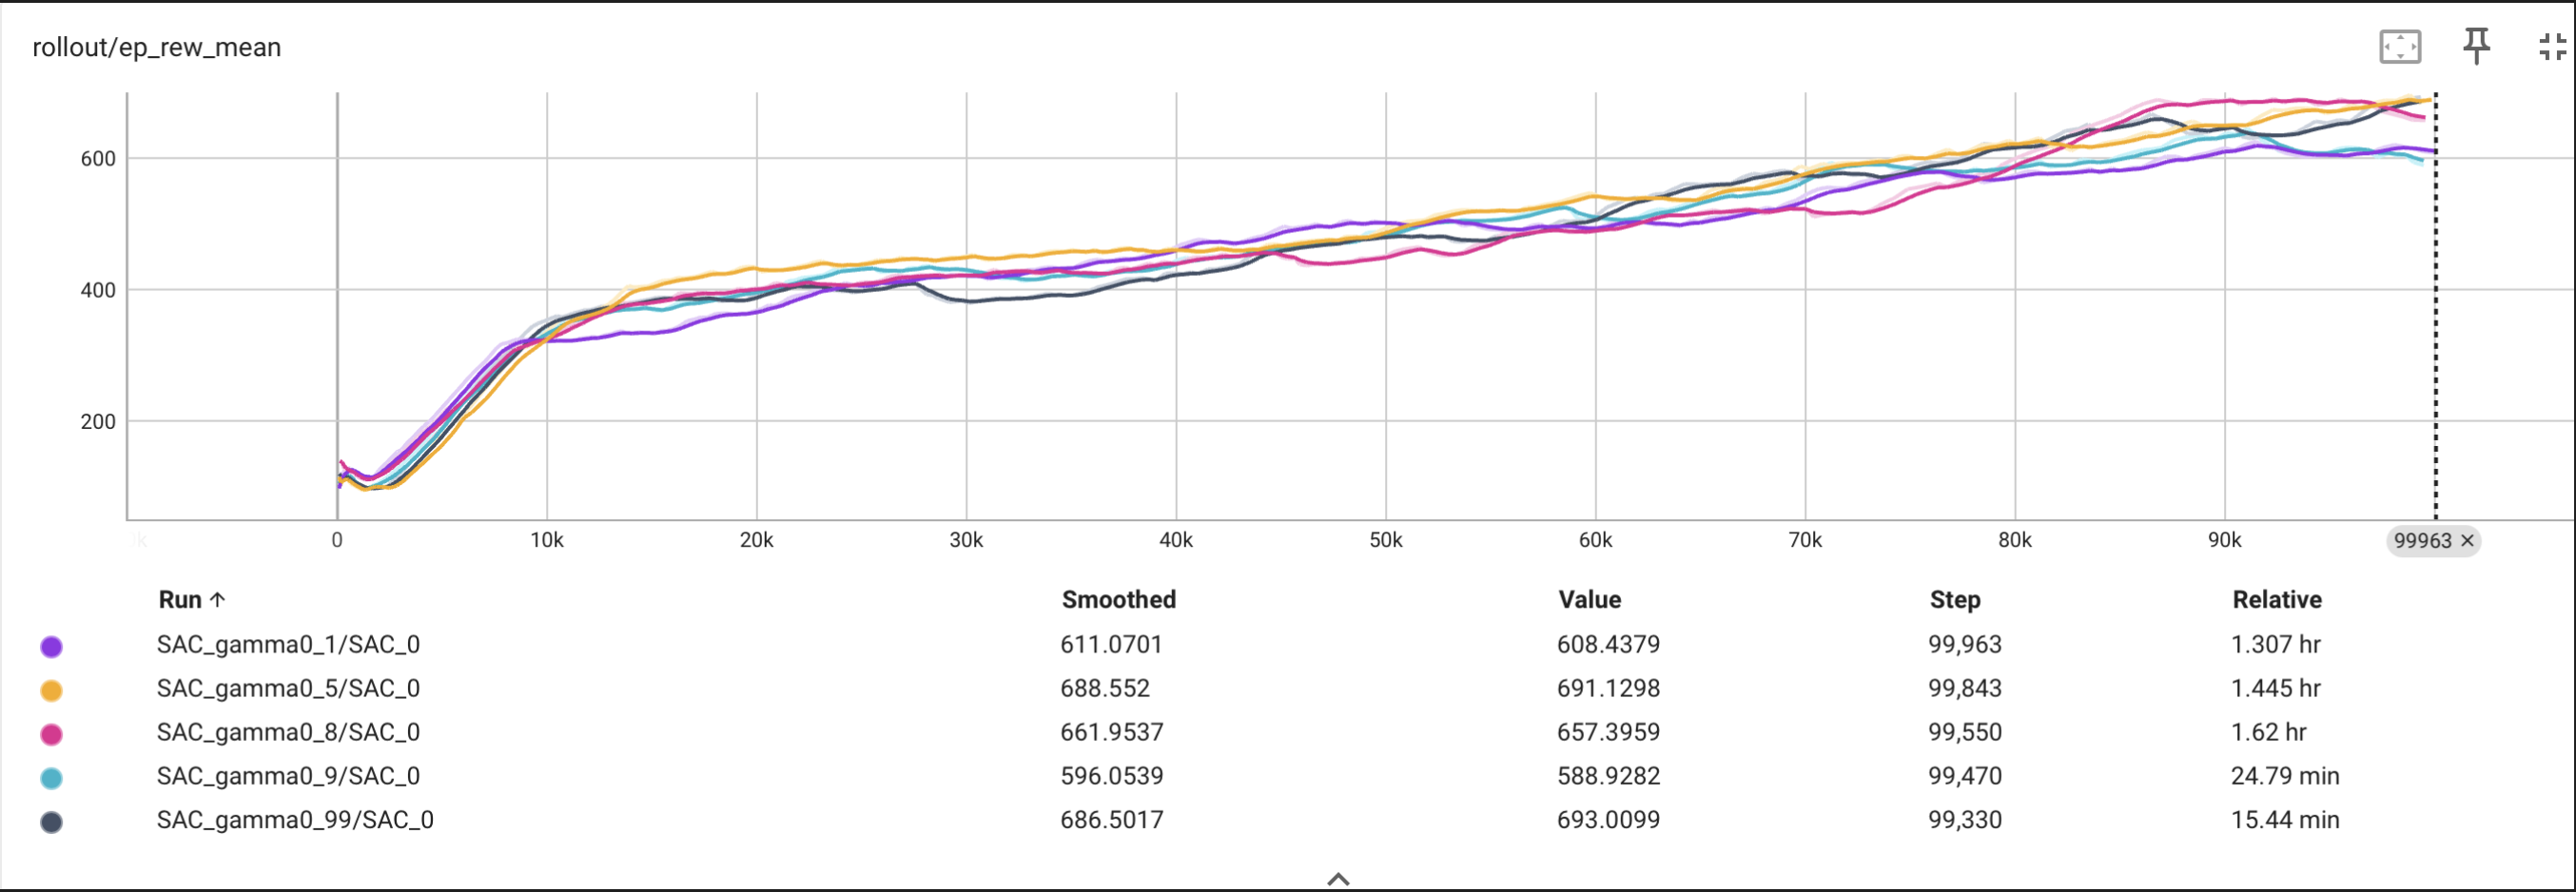

Pierwszy wykres pokazuje średnią długość epizodu w czasie, a drugi średnią nagrodę za epizod. Róne wartości gamma prowadzą do róznych końcowych wyników co wskazuje, że wartość gamma ma wpływ na efektywność uczenia agenta. Wyniki eksperymentu sugerują, że wartość gamma równa 0.99 jest najbardziej optymalna dla naszego środowiska testowego.